## 환경 설정하기

In [ ]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install qwen-vl-utils
# !pip install qwen_agent

In [ ]:
!pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# Tested with transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2, qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1

!pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -U datasets huggingface_hub fsspec
!pip install --upgrade openai
!pip install langchain-openai
!pip install tiktoken
!pip install langgraph
!pip install langchain
!pip install langchain-openai
!pip install langchain_community

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
from huggingface_hub import login
import os

login(
  token=os.getenv("HF_TOKEN"), # ADD YOUR TOKEN HERE
  add_to_git_credential=True
)


## 내 데이터 가져오기

In [ ]:
# SFT를 위한 학습데이터 로드하고 messages 형식으로 변환하기

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import LLMChain

system_prompt = """
    A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
    The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.
    The reasoning process and answer are enclosed within <begin_of_thought><end_of_thought> and <begin_of_solution><end_of_solution> tags,
    respectively, i.e., <begin_of_thought>reasoning process here<end_of_thought><begin_of_solution>answer here<end_of_solution>.
    """

user_prompt = PromptTemplate(
    template="""
    Please conduct an accessibility evaluation of the provided image and related HTML snippet.

    HTML Code: {html}
    """,
    input_variables=["html"],
    )

assistant_prompt = PromptTemplate(
    template="""
<|begin_of_thought|>
{rationale}
<|end_of_thought|>

<|begin_of_solution|>
[평가 요소]: {eval_items}
[평가 근거]: {eval_reason}
[개선 방안]:
{plan}
<|end_of_solution|>
""",
    input_variables=["rationale", "eval_items", "eval_reason", "plan"]
)


def assistant_prompts(outputs):
    prompt = ''
    for output in outputs:
        prompt += assistant_prompt.format(
            rationale=output["rationale"],
            eval_items=output["eval_items"],
            eval_reason=output["eval_reason"],
            plan=output["plan"]
        ) + "\n\n"
    return "<|im_start|>system\n" + prompt.strip() + "\n<|im_end|>"

In [ ]:
from datasets import load_dataset


#Convert dataset to OAI messages
def format_data(sample):
  return {"messages": [
              {
                  "role": "system",
                  "content": [{"type": "text", "text": system_prompt}],
              },
              {"role": "user",
                         "content": [{
                             "type": "text",
                             "text": user_prompt.format(html=sample["html"]),
                         },
                         {
                             "type": "image", "image": sample["image"]
                         }
                  ],
              },
              {"role": "assistant",
                         "content": [{
                             "type": "text",
                             "text": assistant_prompts(sample["output"])
                         }],
              },
          ],
      }

dataset_id = "doodoo77/For_VLM_accessibility"
dataset = load_dataset(dataset_id, split="train")

dataset = [format_data(sample) for sample in dataset]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset[6]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': '\n    A conversation between User and Assistant. The user asks a question, and the Assistant solves it.\n    The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\n    The reasoning process and answer are enclosed within <begin_of_thought><end_of_thought> and <begin_of_solution><end_of_solution> tags,\n    respectively, i.e., <begin_of_thought>reasoning process here<end_of_thought><begin_of_solution>answer here<end_of_solution>.\n    '}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': '\n    Please conduct an accessibility evaluation of the provided image and related HTML snippet.\n\n    HTML Code: <img alt="교실 배경 이미지" class="bg" src="../img/custom/grade5/p5_l4_bg.png">\n<img alt="양갈래 검정 머리 여자아이" src="../img/custom/grade5/p5_l4_01.png">\n<img alt="양갈래 검정 머리 여자아이" class="hover" src="../img/custom/grade5/p5_l4_01_h.png">\n<img alt="노란머리

## Model 및 Processor 선언하기

In [ ]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# Hugging Face model id
model_id = "Qwen/Qwen2-VL-7B-Instruct"

# BitsAndBytesConfig int-4 config
"""
Qlora를 위해 4비트 양자화를 진행함.

1. 기존 VLM의 파리미터 값을 4비트로 양자화함. (즉, 모든 파라미터 값들을 16가지 값들중 하나로 표현한다는 것임).
   근데 원래 값으로 정규분포를 사용해 복원도 가능함. 이게 놀라운 것임
2. 학습데이터를 기반으로 LoRA adapter 내의 있는 파라미터를 학습함. 이때는 정밀한 loss 계산을 위해 16비트로 표현한 값을 사용함
3. 학습된 LoRA adapter는 full-precision 상태로 저장되고 추론할 때 사용됨
"""
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
"""
AutoModelForVision2Seq는 VLM을 로드하기 위한 Hugging Face Transformers의 클래스임
"""
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

"""
AutoProcessor은 이미지, 텍스트 입력 등 다양한 멀티모달 입력에 대해 전처리 및 후처리를 진행하는 클래스임
"""
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


## Lora 하이퍼파라미터 설정할기

In [ ]:
# Lora parameter
# Lora paramter 설정 시 참고할만한 블로그
# https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms
# https://www.youtube.com/watch?v=t1caDsMzWBk

from peft import LoraConfig

"""

- lora_alpha는 학습률로 클 수록 overfitting 되기 쉬우니, 데이터셋이 다양한할때 사용함
- r는 adapter의 중간 차원의 크기임. 보통 lora_alpha의 절반을 사용하는게 좋음 - link
- target_modules -> 즉 lora를 적용한 layer는 attention layer(q_proj, v_proj, k_proj, o_proj)와
MLP layer(gate_proj, up_proj, down_proj) 모두에 적용하는게 좋음

"""

peft_config = LoraConfig(
    lora_alpha = 16, # alpha값은 보통 rank, r값의 2배로 설정함. 근데 qlora에서는 16/64=1/4로 설정함
                     # alpha/rank: scale multiplier -> lora 파라미터 변화량에 곱해져 학습속도에 영향을 줌
                     # 즉, alpha값을 고정하고 learning rate를 조정하는 방향을 추천함

    lora_dropout = 0.1, # overfitting을 막기 위해 파라미터의 일정 비율로 랜덤하게 가중치를 0으로 만듦
                        # 7b-13b에서는 0.1/ 33b-65b에서는 0.05

    r = 8, # rank 값이 클수록 더 복잡한 작업을 수행할 수 있음
            # LoRA의 rank는 model의 원래 weight matrix를 근사하는 데 사용하는 두 작은 행렬의 중간 차원임
            # 즉, 크기 의 두 행렬을 곱하여 d x r, r x d의 두 행렬을 곱해 원래 d x d 행렬을 근사할 때 이 중간 r을 rank라고 부름
            # 근데, QLora에서는 이 r값이 8~256 사이에 있으면 큰 영향이 없음
            # QLora에서는 r값을 64로 시작함

    bias = "none",
    target_modules=["q_proj", "v_proj"], # 다 추가하라면서 왜 해당 layer만 추가한거지?
    task_type="CAUSAL_LM",
)


## SFT 하이퍼파라미터 설정하기

In [ ]:
# Qlora 논문에서는 Dataset마다 적절한 training hyperparameters를 추천함. 참고하기

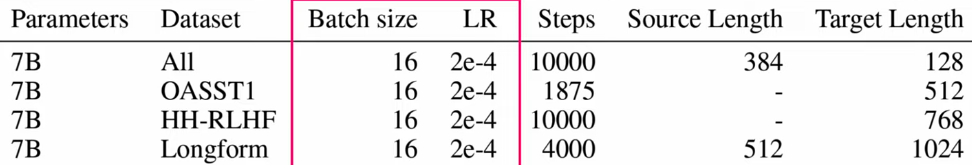

In [ ]:
#Define hyper-parameters
from trl import SFTConfig
from transformers import Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

args = SFTConfig(
    output_dir = "qwen2-7b-instruct-description", #파라미터 저장할 파일 경로
    num_train_epochs=10, #epoch수
    per_device_train_batch_size=2, #배치사이즈, 클수록 좋지만 메모리 사이즈 고려해서 값 설정
    gradient_accumulation_steps = 32, #지정 수 만큼 그레디언트 누적 후 한번에 backpropagation 수행
    gradient_checkpointing = True, #계산시 사용되는 메모리 아끼기 위한 방법임. 계산의 중간값들을 계산하지 필요할 때 다시 계산함
    optim = "adamw_torch_fused", #옵티마이저 설정함
    logging_steps = 5, #log 정보를 출력한 step 단위
    save_strategy = "epoch", #epoch마다 파라마터를 저장함. checking point가 epoch임
    learning_rate = 2e-4, #학습률
    bf16=True, # use bfloat16 precision
    tf32=True, # use tf32 precision
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


## Collate: batch size의 데이터셋 만들기

In [ ]:
#Create custom dataset
#이미지 입력을 처리하기 위해서 Qwen2 모델은 process_vision_info 메서드를 지원함/ 다른 모델 사용할때 해당 모델이 지원하는 메서드를 확인해야 함

#Data collator, 데이터를 배치사이즈로 묶는 작업을 진행함
def collate_fn(examples):

  #apply_chat_template는 messages 에 정의된 prompt를 role에 따라 정리함 text로
  #이때 image 태그도 포함됨. 이거 학습하게 하지 않기 위해 뒤에서 이 부분 제거해줘야 함
  #이때 tokenize=False 이면 출력을 string으로 제공함
  """
  <|system|>
  You are a helpful assistant.
  <|user|>
  What is the category of the Apple iPhone? <image>
  <|assistant|>
  Smartphones.
  """
  texts = [processor.apply_chat_template(example["messages"], tokenizer=False) for example in examples]

  #process_vision_info의 역할은
  # 1) messages안에 있는 다양한 형식으로 정의된 image("http://", "file://", "data:image")에 대해서 PIL.Image.Image 객체로 변환하고
  # 2) 이미지의 크기를 리사이즈함
  image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

  #Tokenize the texts and process the images
  batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

  """
    위 processor의 출력은 VLM(Vision-Language Model)에 입력으로 들어갈 수 있도록
    텍스트와 이미지를 각각 PyTorch 텐서 형태로 전처리한 결과입니다.

    1. input_ids (torch.LongTensor):
       - apply_chat_template로 생성된 텍스트를 tokenizer가 정수 인덱스 시퀀스로 토큰화한 결과
       - shape: (batch_size, sequence_length) # system·user·assistant 역할이 포함된 전체 대화 시퀀스를 토큰화한 뒤,
                                              # 배치 내 가장 긴 시퀀스에 맞춰 padding을 적용한 결과
       - 예: [[101, 1045, 2293, 2023, 3185, 102], [...], ...]

    2. attention_mask (torch.LongTensor):
       - input_ids에서 실제 토큰은 1, padding된 위치는 0으로 마스킹
       - shape: (batch_size, sequence_length)
       - 예: [[1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0], ...]

    3. pixel_values (torch.FloatTensor):
       - vlm이 이해할 수 있는 형태로 텐서 변환 진행
       - shape: (batch_size, num_channels, height, width)
       - 예: (2, 3, 224, 224) → RGB 이미지 2장, 224x224 픽셀
       - 각 픽셀 값은 0~1 사이로 정규화되며, vision encoder 입력으로 사용됨
  """


  # 이제 input_ids는 정답 처리가 될거임. 현재는 입력과 출력에 대한 정보를 모두 Instruction model의 상황임
  # 대체로는 출력만 학습하도록 설계함
  # 이를 위해 현재 input_ids에는 <image>, padding의 임베딩 벡터들을 찾아서 무의미한 값으로 바꿀것임

  labels = batch["input_ids"].clone()
  #pad token 무시하기
  labels[labels == processor.tokenizer.pad_token_id] = -100

  #이미지 태그 무시하기
  if isinstance(processor, Qwen2VLProcessor):
    image_tokens = [151652,151653,151655]
  else:
    image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
  for image_token_id in image_tokens:
    labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

Insturction Modeling(IM)
- 기존에는 출력만 학습하는데 반해, 입력과 출력 모두를 학습시키는 방법임
- 이 방법은 입력이 출력에 비해 상당히 길거나, 학습데이터 수가 적을 때 효과적인 방법임. 이때 overfitting이 많이 되는데 IM이 이런 효과를 줄여줌
- 즉, 학습자원이 부족할 때 실용적인 방법이란것임!

In [ ]:
#SFTTrainer를 통해서 학습을 진행함

from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## processor.apply_chat_template 예시

In [ ]:
# from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

# model = LlavaOnevisionForConditionalGeneration.from_pretrained("llava-hf/llava-onevision-qwen2-0.5b-ov-hf")
# processor = AutoProcessor.fro.m_pretrained("llava-hf/llava-onevision-qwen2-0.5b-ov-hf")

# messages = [
#     {
#       "role": "system",
#       "content": [{"type": "text", "text": "You are a friendly chatbot who always responds in the style of a pirate"}],
#     },
#     {
#       "role": "user",
#       "content": [
#             {"type": "image", "url": "http://images.cocodataset.org/val2017/000000039769.jpg"},
#             {"type": "text", "text": "What are these?"},
#         ],
#     },
# ]

In [ ]:
# processed_chat = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False, return_dict=True, return_tensors="pt")
# processed_chat

In [ ]:
# processed_chat = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt")
# processed_chat

## Train model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 훈련 시작
trainer.train()

# 모델 저장
trainer.save_model(args.output_dir)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,7.694100
10,7.123600


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/uti

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob

# 현재 작업 디렉터리 확인
print("cwd:", os.getcwd())

# 모델 폴더가 실제로 있는지 확인
print(glob.glob("qwen2-7b-instruct-description/*"))

cwd: /content
['qwen2-7b-instruct-description/checkpoint-6', 'qwen2-7b-instruct-description/tokenizer.json', 'qwen2-7b-instruct-description/checkpoint-4', 'qwen2-7b-instruct-description/adapter_config.json', 'qwen2-7b-instruct-description/README.md', 'qwen2-7b-instruct-description/special_tokens_map.json', 'qwen2-7b-instruct-description/tokenizer_config.json', 'qwen2-7b-instruct-description/checkpoint-2', 'qwen2-7b-instruct-description/chat_template.jinja', 'qwen2-7b-instruct-description/checkpoint-8', 'qwen2-7b-instruct-description/checkpoint-9', 'qwen2-7b-instruct-description/runs', 'qwen2-7b-instruct-description/checkpoint-1', 'qwen2-7b-instruct-description/checkpoint-10', 'qwen2-7b-instruct-description/added_tokens.json', 'qwen2-7b-instruct-description/checkpoint-3', 'qwen2-7b-instruct-description/adapter_model.safetensors', 'qwen2-7b-instruct-description/vocab.json', 'qwen2-7b-instruct-description/checkpoint-5', 'qwen2-7b-instruct-description/training_args.bin', 'qwen2-7b-instruct

In [ ]:
!cp -r /content/qwen2-7b-instruct-description /content/drive/MyDrive/VLM_checkpoints